# pybacktest框架介紹-MA策略回測
[pybacktest](https://github.com/ematvey/pybacktest)是一個基於pandas的vectorized回測框架，這個框架可能不太適合更專業的回測需求，但剛好適合我們練習需求，讓我們看看怎麼用pybacktest來回測一個簡單的MA策略。

## MA策略
主要的想法是，我們計算兩個移動平均線，一條是長線，用來捕捉長期是，一條是短線，用來捕捉短期趨勢，當短線從下方突破長線則代表短期向上動能強，則我們買進，而短線從上方突破，則我們賣出。

In [1]:
#載入套件庫與讀入資料
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

db = sqlite3.connect('TWStock_2')
tsmc = pd.read_sql(con=db,sql='SELECT * FROM "2330"')

### 整理資料
根據官方教學，這邊 pybacktest預設接受pandas.DataFrame格式，然後索引值為時間，columns則為 O,H,L,C，所以我們把格式整理為需要的形式。

In [2]:
#清理資料
#我們需要成交股數、開盤價、最高價、最低價、收盤價的資料
#並使用Date當作我們的索引值

tsmc.index = pd.to_datetime(tsmc['Date'])
tsmc = tsmc[['開盤價','最高價','最低價','收盤價']]
tsmc.columns = ['O','H','L','C']
cols = tsmc.columns
tsmc[cols] = tsmc[cols].apply(pd.to_numeric, errors='coerce')

In [3]:
tsmc.head()

,O,H,L,C
Date,,,,
2014-06-19,124.5,126.0,124.5,126.0
2014-06-20,126.5,127.0,124.0,124.5
2014-06-23,125.0,125.5,123.0,123.0
2014-06-24,123.0,123.5,122.0,123.0
2014-06-25,123.0,124.5,123.0,123.5


In [4]:
#載入pybacktest

import pybacktest    

pybacktest是基於一串交易訊號序列進行回測計算，我們只要把回測訊號算出來就可以進行回測了。

In [15]:
short_ma = 50
long_ma = 200

short_mavg = tsmc['C'].rolling(short_ma).mean()
long_mavg = tsmc['C'].rolling(long_ma).mean()

buy = cover = (short_mavg > long_mavg) & (short_mavg.shift() < long_mavg.shift()) # ma cross up
sell = short = (short_mavg < long_mavg) & (short_mavg.shift() > long_mavg.shift()) # ma cross down


在這邊，pybacktest任一個特殊的變數名ohlc當作他的bar價格資料，所以我命名ohlc = tsmc.copy()

In [16]:
ohlc = tsmc.copy()

pybacktest.Backtest的第一個變數填入我們需要用來計算的信號以及價格資料，接受的資料格式是字典或是DataFrame，這邊我們使用loacls()將所有明明過得變數丟進去。

In [17]:
bt = pybacktest.Backtest(locals(), 'ma_cross')  

pybacktest在呼叫屬性才會進行計算，我們可以呼叫的屬性有下列

In [18]:
print(list(filter(lambda x: not x.startswith('_'), dir(bt))))

['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'stats', 'summary', 'trade_price', 'trades', 'trdplot']


In [9]:
bt.trades

,pos,price,vol
Date,,,
2015-12-17,1.0,144.5,1.0
2018-06-05,0.0,230.0,-1.0
2018-09-06,1.0,268.0,1.0
2018-11-29,0.0,231.5,-1.0
2019-04-11,1.0,253.0,1.0


In [19]:
 bt.signals.tail()

,Buy,Cover,Sell,Short
Date,,,,
2019-06-04,False,False,False,False
2019-06-05,False,False,False,False
2019-06-06,False,False,False,False
2019-06-10,False,False,False,False
2019-06-11,False,False,False,False


In [11]:
bt.positions

Date
2014-06-19    0.0
2015-12-16    1.0
2018-06-04    0.0
2018-09-05    1.0
2018-11-28    0.0
2019-04-10    1.0
dtype: float64

In [20]:
bt.equity

Date
2015-08-06     0.0
2015-12-17    -8.5
2018-06-05    85.5
2018-09-06   -38.0
2018-11-29   -36.5
2019-04-11   -21.5
dtype: float64

In [21]:
bt.summary()

----------------------------------------------
|  Backtest(ma_cross, 2019-27-06 13:16 BST)  |
----------------------------------------------

backtest:
  days: 1211
  from: '2015-12-17 00:00:00'
  to: '2019-04-11 00:00:00'
  trades: 5
performance:
  PF: 0.8182
  RF: -0.1979
  averages:
    gain: 85.5
    loss: -26.125
    trade: -3.8
  payoff: 3.2727
  profit: -19.0
  winrate: 0.2
risk/return profile:
  MPI: -0.0081
  UPI: -0.0667
  WCDD (monte-carlo 0.99 quantile): 104.5
  maxdd: 96.0
  sharpe: -0.084
  sortino: -0.0179

----------------------------------------------


(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46169173c8>)

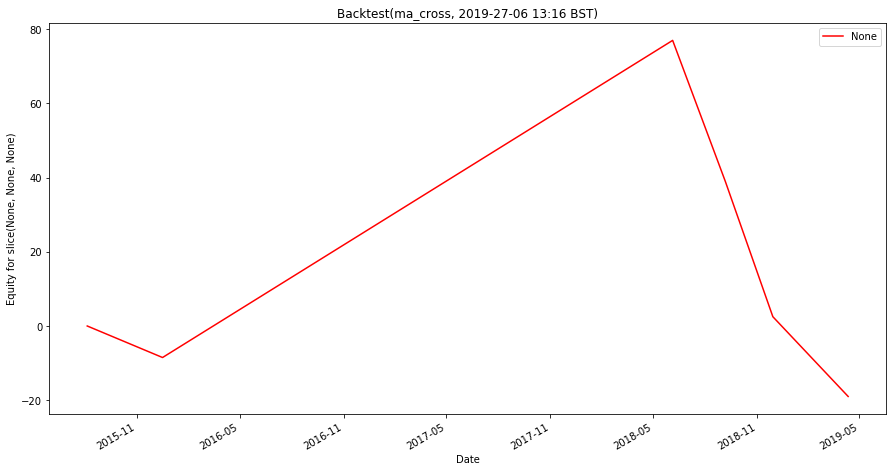

In [22]:


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

bt.plot_equity()



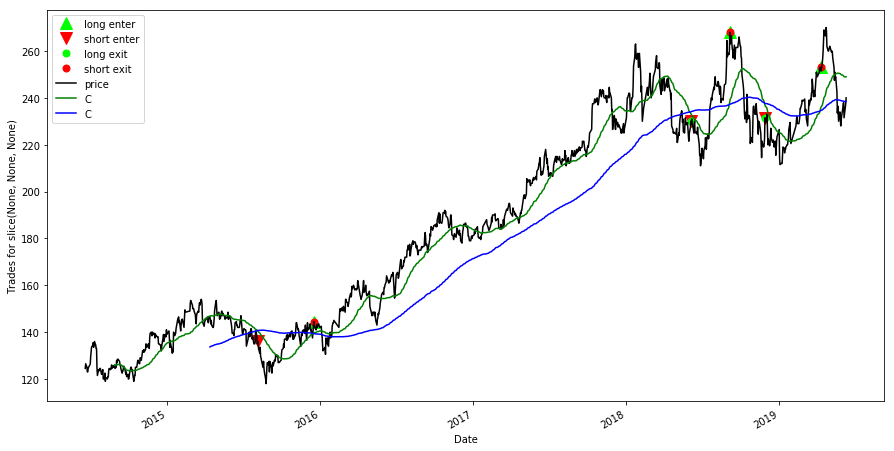

In [23]:
bt.plot_trades()
ohlc.C.rolling(short_ma).mean().plot(c='green')
ohlc.C.rolling(long_ma).mean().plot(c='blue')
plt.legend(loc='upper left')
pass

## 小結
這邊只是簡單介紹如何使用pybacktest來進行回測分析，相較於zipline，pybacktest相對陽春一些，但是整體語法也更為簡單好上手，我們下集會在做更進一步的介紹。